In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline

# How Much is Your Car Worth?

Data about the retail price of 2005 General Motors cars can be found in `car_data.csv`.

The columns are:

1. Price: suggested retail price of the used 2005 GM car in excellent condition.
2. Mileage: number of miles the car has been driven
3. Make: manufacturer of the car such as Saturn, Pontiac, and Chevrolet
4. Model: specific models for each car manufacturer such as Ion, Vibe, Cavalier
5. Trim (of car): specific type of car model such as SE Sedan 4D, Quad Coupe 2D          
6. Type: body type such as sedan, coupe, etc.      
7. Cylinder: number of cylinders in the engine        
8. Liter: a more specific measure of engine size     
9. Doors: number of doors           
10. Cruise: indicator variable representing whether the car has cruise control (1 = cruise)
11. Sound: indicator variable representing whether the car has upgraded speakers (1 = upgraded)
12. Leather: indicator variable representing whether the car has leather seats (1 = leather)

In [2]:
df = pd.read_csv('car_data.csv')
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


## Tasks, Part 1

1. Find the linear regression equation for mileage vs price.
2. Chart the original data and the equation on the chart.
3. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)

In [3]:
#regr = linear_model.LinearRegression()
# X = df[['Mileage']]
# y = df['Price']
# regr.fit(X, y)

In [4]:
def lin_reg(X,y):
    """Perform linear regression and return slope, intercept, R^2, and the regression object"""
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    slope = regr.coef_
    intercept = regr.intercept_
    score = regr.score(X, y)
    return slope, intercept, score, regr
    
def lr_eqn(X,y):
    """Return the formatted equation and R^2 score of a linear regression"""
    # mbr = tuple(map(lambda x: round(x,3),lin_reg(X,y)[0:3]))
    mbr = lin_reg(X,y)[0:3]
    return 'y = {}*x + {} \n R^2={}'.format(*mbr)

def lr_plot(X,y, title):
    """Plot scatter(X,y) plus linear regression line and values, with title"""
    fig, ax = plt.subplots(1)
    regr = lin_reg(X, y)[3]
    ax.scatter(X, y)
    
    ax.plot(X, regr.predict(X), color='blue', linewidth=3)
    
    textstr = lr_eqn(X, y)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.25, 0.1, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    plt.title(title, fontsize=14)
    return fig, ax
    

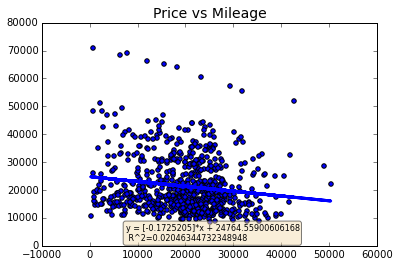

In [5]:
X = df[['Mileage']]
y = df['Price']
fig, ax = lr_plot(X, y, 'Price vs Mileage')

###Conclusion: This is a poor fit to the data (R^2 << 0.8)

## Tasks, Part 2

1. Use mileage, cylinders, liters, doors, cruise, sound, and leather to find the linear regression equation.
2. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)
3. Find the combination of the factors that is the best predictor for price.

In [6]:
df.head(1)

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1


In [7]:
X = df.loc[:,['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather']]
y = df['Price']
lr_eqn(X,y)

'y = [ -1.69747832e-01   3.79237893e+03  -7.87220732e+02  -1.54274585e+03\n   6.28899715e+03  -1.99379528e+03   3.34936162e+03]*x + 6758.755143598082 \n R^2=0.4462643536728379'

###Not a good fit (R < 0.8)

In [8]:
import itertools
dependent_vars = ['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather']
#dependent_vars.remove('Price')
#combos = list(itertools.combinations(dependent_vars, 5))


In [18]:
def regression_for(combo):
    """Uses global df"""
    combo = list(combo)
    d = df.loc[:, combo + ['Price']]
#     df.dropna(inplace=True)
    input_data = df[combo]
    price = df['Price']
    regr = linear_model.LinearRegression()
    regr.fit(input_data, price)
    return regr, regr.score(input_data, price)

def test_regression(combos):
    """Uses global df"""
    choices = []
    for combo in combos:
        regr, score = regression_for(combo)
        choices.append((combo, score))

    best = sorted(choices, key=lambda x: x[1])[-1]
    #print(best)
    regr, score = regression_for(best[0])
    #print(regr.coef_, regr.intercept_)
    return best

def best_regression(n, min=1):
    """Uses global df"""
    min = 1 if min < 1 else min
    scores = []
    for i in range(min, n+1):
        scores.append(test_regression(list(itertools.combinations(dependent_vars, i))))
    return scores

In [10]:
best_regression(7)

[(('Cylinder',), 0.32385903759512258),
 (('Cylinder', 'Cruise'), 0.38394913240273443),
 (('Cylinder', 'Cruise', 'Leather'), 0.40380272693971553),
 (('Mileage', 'Cylinder', 'Cruise', 'Leather'), 0.42250742147747633),
 (('Mileage', 'Cylinder', 'Doors', 'Cruise', 'Leather'), 0.4369402151237245),
 (('Mileage', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather'),
  0.44569092105870245),
 (('Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'),
  0.4462643536728379)]

###Conclusion: The 7-factor model is marginally better than the 4-factor model listed above, but none of the combinations is a very good fit (R < 0.8)

## Tasks, Hard Mode

1. Research dummy variables in scikit-learn to see how to use the make, model, and body type.
2. Find the best combination of factors to predict price.

In [11]:
df = pd.read_csv('car_data.csv')
df_orig = df

In [12]:
dummies = pd.get_dummies(df[['Make', 'Model', 'Type']]).set_index(df.index)
df = pd.merge(df, dummies, left_index=True, right_index=True)
for col in ['Make', 'Model', 'Trim', 'Type']:
    df.pop(col)


In [13]:
dependent_vars

['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather']

In [ ]:
dependent_vars = list(df.columns)
dependent_vars.remove('Price')

In [24]:
%%time
best_regression(2)

CPU times: user 2.62 s, sys: 18.9 ms, total: 2.64 s
Wall time: 2.7 s


[(('Make_Cadillac',), 0.43467222055774146),
 (('Cylinder', 'Make_SAAB'), 0.67113089332616738)]

###The dummy variable for Saab makes significantly improves the fit, even with only 2 of the 55 available factors

In [25]:
%%time
best_regression(3,min=3)

CPU times: user 39.8 s, sys: 288 ms, total: 40.1 s
Wall time: 40.9 s


[(('Liter', 'Make_Cadillac', 'Make_SAAB'), 0.83719848633355731)]

###Adding Cadillac-ness of cars gives a R^2 score greater than 0.8 with 3 factors.
However, finding this combination is beginning to take significant time

In [26]:
%%time
best_regression(4,min=4)

CPU times: user 7min 43s, sys: 3.17 s, total: 7min 47s
Wall time: 7min 57s


[(('Liter', 'Make_Cadillac', 'Make_SAAB', 'Model_XLR-V8'),
  0.90137021193683908)]

###After about 8 minutes, we see a 4-factor model with a score of 0.9
But it seems strange that 3 of the 4 factors are make or model, since the majority of the cars have values of 0 for these 3 factors
Also, it is difficult to visualize the fit for these higher-order feature vectors in order to provide a sanity-check.

In [28]:
%%time
best_regression(5,min=5)

CPU times: user 1h 12min 47s, sys: 33.8 s, total: 1h 13min 21s
Wall time: 2h 25min 40s


[(('Liter', 'Make_Cadillac', 'Make_SAAB', 'Model_XLR-V8', 'Type_Convertible'),
  0.92407221123940209)]

###This took over an hour to run, and shows that the Convertible-ness of cars has a small additional effect